### 3. Evaluate the model on the test set with (Precision- Recall Curve) and calculate Accuracy on train/val/test

#### 3.1 Evaluate precision-recall curve and calculate precisions across all classess when recall = 1

in order to evaluate precision-recall curve we defined 10 function.

1. Run YOLO-based object detection model.

2. It reads test images and annotations, performs object detection, and matches predictions to ground truth using IoU and Hungarian matching. 

3. It then calculates precision, recall, AP, and AUC-PR for each class, generates precision-recall curves, and saves the results for analysis.

4. Finally, it computes and displays micro-average precision and AUC-PR across all classes

another objective is calculating first elements of precisions across all classes when recall = 1, meaning the model successfully predicts all objects in each class.
then we draw a grapg of it.

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import glob
from tqdm import tqdm
import scipy.optimize
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from icecream import ic


# Initialize counters for precision-recall and AUC-PR data
def initialize_pr_data(num_classes):
    return {
        'true_labels': [[] for _ in range(num_classes)],  # to store  true labels across each class individually
        'confidences': [[] for _ in range(num_classes)],   # to store confidence scores across each class individually
        'global_true_labels': [],                          # store true labels across all classes
        'global_confidences': []                            # store confidence scores across all classes
    }
  
    

# Specifies paths for images, annotations, and the pre-trained YOLO model checkpoint
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
jpeg_images_path = "JPEGImages"
test_image_path = os.path.join(jpeg_images_path, "test")
best_weights_path = os.path.join(base_path, 'runs/detect/train/weights', 'best.pt')




# Maps class IDs to corresponding class labels for easier interpretation
def class_to_label(class_id):
    classes = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
    return classes[class_id], len(classes)




# Loads ground truth bounding boxes (in YOLO format) from .txt annotation files
def read_txt_annotations(file_path):
    annots = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        elems = line.split()
        annots[int(elems[0])] = [float(elems[1]), float(elems[2]), float(elems[3]), float(elems[4])]
    return annots




# Convert YOLO bounding boxes from [cx, cy, w, h] to [x1, y1, x2, y2] 
def convert_whn_to_xyxy(box_whn, img_width, img_height):
    center_x, center_y, width, height = box_whn
    x_min = int((center_x - width / 2) * img_width)
    y_min = int((center_y - height / 2) * img_height)
    x_max = int((center_x + width / 2) * img_width)
    y_max = int((center_y + height / 2) * img_height)
    return [x_min, y_min, x_max, y_max]



# Computes the IoU between predicted and ground truth bounding boxes for evaluating detection accuracy
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[3], boxA[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou



# Matches detected objects with ground truth objects using the Hungarian algorithm based on IoU value
def find_all_gt_labels(final_items, annots, img_width, img_height):
    cost_matrix = []
    keys = list(annots.keys())

    for item in final_items:
        pred_box_xyxy = convert_whn_to_xyxy(item['box_xywhn'], img_width, img_height)
        
        ious = []
        for k in keys:
            gt_box_xyxy = convert_whn_to_xyxy(annots[k], img_width, img_height)
            ious.append(bb_intersection_over_union(pred_box_xyxy, gt_box_xyxy))
        
        cost_matrix.append(1 - np.array(ious))  # We want to minimize 1 - IoU
    
    # Perform Hungarian matching
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    
    
    
    # Assign best matching ground truth to each prediction
    matched_items = []
    for i, l in enumerate(col_ind):
        final_items[i]['gt_id'] = keys[l]
        final_items[i]['gt_label'] = class_to_label(keys[l])[0]
        matched_items.append(final_items[i])
    
    return matched_items




# Loads the YOLO model, detects objects in images, and stores predicted bounding boxes, confidence scores, and class IDs
def detect_and_match_objects(image_path, yolo_weights_path, pr_data, num_classes):
    annotations_path = image_path.replace('.jpg', '.txt')
    annotations = read_txt_annotations(annotations_path)

    model = YOLO(yolo_weights_path).to('cuda')
    results = model(image_path)

    detected_items = []
    for result in results:
        for box in result.boxes:
            confidence = box.conf.item()
            class_id = int(box.cls.item())
            label = class_to_label(class_id)[0]
            detected_items.append({
                'confidence': confidence,
                'box_xywhn': box.xywhn[0].cpu().numpy().tolist(),
                'class_id': class_id,
                'label': label
            })

    # Get image dimensions
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # Perform Hungarian matching between predictions and ground truth
    final_items = find_all_gt_labels(detected_items, annotations, img_width, img_height)
    
    

    # keep track of model's prediction for each class/ true positives and false positives so that later we can use for calculating precision and recall curve
    for item in final_items:
        class_id = item['class_id']
        confidence = item['confidence']
        gt_label = item['gt_label']

        pr_data['confidences'][class_id].append(confidence)                                           # keep track of confidence score per class
        pr_data['true_labels'][class_id].append(1 if class_to_label(class_id)[0] == gt_label else 0)  #keep track of true labels per class

        pr_data['global_confidences'].append(confidence)                                              # tracks confidence scores for predictions across all classes
        pr_data['global_true_labels'].append(1 if class_to_label(class_id)[0] == gt_label else 0)     # keep track of true labels per class
    
        
        
               
# Calculate precision, recall, Average Precision (AP), and AUC-PR for each class and the global average
def calculate_precision_recall_auc_sk(pr_data, num_classes):
    aps = []                #store average precisions
    auc_prs = []            # store auc-pr for each class
    for class_id in range(num_classes):
        if len(pr_data['true_labels'][class_id]) == 0:
            continue
        
        confidences = np.array(pr_data['confidences'][class_id]) # convert confidence score  to numpy array for later processing
        true_labels = np.array(pr_data['true_labels'][class_id])   # convert true labels on each class id to numpy array for further processing

        # Sort by confidence
        sorted_indices = np.argsort(-confidences)   #The predictions are sorted by their confidence scores in descending order

        true_labels = true_labels[sorted_indices]    # Both true_labels and confidences arrays are rearranged according to this sorted order
        confidences = confidences[sorted_indices]
        
        # Calculate precision, recall, and AUC using scikit-learn
        precision, recall, _ = precision_recall_curve(true_labels, confidences)
        ic(precision[0], recall[0], class_id) # the first element (precision[0] and recall[0]) corresponds to the highest confidence threshold

        auc_pr = auc(recall, precision)
        ap = average_precision_score(true_labels, confidences)

        aps.append(ap)
        auc_prs.append(auc_pr)

    # Calculate micro-average precision, recall, and AUC
    global_true_labels = np.array(pr_data['global_true_labels'])
    global_confidences = np.array(pr_data['global_confidences'])
    precision_micro, recall_micro, _ = precision_recall_curve(global_true_labels, global_confidences)
    auc_pr_micro = auc(recall_micro, precision_micro)
    ap_micro = average_precision_score(global_true_labels, global_confidences)

    # Calculate mAP and mean AUC-PR
    mAP = np.mean(aps) if aps else 0
    mean_auc_pr = np.mean(auc_prs) if auc_prs else 0
    return mAP, mean_auc_pr, ap_micro, auc_pr_micro, precision_micro, recall_micro





# Plot Precision-Recall curve, including AP and AUC-PR for each class and micro-average
def plot_pr_curve(pr_data, num_classes, mAP, mean_auc_pr, ap_micro, auc_pr_micro, precision_micro, recall_micro):
    plt.figure(figsize=(10, 8))

    for class_id in range(num_classes):
        if len(pr_data['true_labels'][class_id]) == 0:
            continue
        confidences = np.array(pr_data['confidences'][class_id])
        true_labels = np.array(pr_data['true_labels'][class_id])
        precision, recall, _ = precision_recall_curve(true_labels, confidences)

        plt.plot(recall, precision, 
                 label=f"{class_to_label(class_id)[0]} (AP: {average_precision_score(true_labels, confidences):.2f}, AUC-PR: {auc(recall, precision):.2f})")

    # Plot micro-average precision-recall curve
    plt.plot(recall_micro, precision_micro, linestyle='--', color='black',
            label=f'Micro-Average (AP: {ap_micro:.2f}, AUC-PR: {auc_pr_micro:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Each Class with AP, mAP = {mAP:.2f}, AUC-PR = {mean_auc_pr:.2f}')
    plt.legend(loc='lower left')
    plt.grid(True)

    # Save the plot to a file
    plot_file_path = os.path.join(base_path, "precision_recall_curve_with_micro_average.png")
    plt.savefig(plot_file_path)
    print(f"Precision-Recall curve saved to {plot_file_path}")
    
    

# Process the test dataset and generate Precision-Recall curves with AP, AUC-PR, and micro-average
def process_test_set():
    # Get number of classes
    _, num_classes = class_to_label(0)
    
    # Initialize PR data for each class
    pr_data = initialize_pr_data(num_classes)

    # Test Set
    test_files = glob.glob(os.path.join(test_image_path, '*.jpg'))

    # Process all test images
    for image_path in tqdm(test_files):
        detect_and_match_objects(image_path, best_weights_path, pr_data, num_classes)

    # Calculate precision, recall, AP, and AUC-PR
    mAP, mean_auc_pr, ap_micro, auc_pr_micro, precision_micro, recall_micro = calculate_precision_recall_auc_sk(pr_data, num_classes)

    # Plot Precision-Recall Curve and display AP, AUC-PR, and micro-average for each class
    plot_pr_curve(pr_data, num_classes, mAP, mean_auc_pr, ap_micro, auc_pr_micro, precision_micro, recall_micro)

    # Print mAP and mean AUC-PR
    print(f"\nMean Average Precision (mAP): {mAP:.2f}")
    print(f"Mean AUC-PR: {mean_auc_pr:.2f}")
    print(f"Micro-Average Precision: {ap_micro:.2f}")
    print(f"Micro-Average AUC-PR: {auc_pr_micro:.2f}")



# Run the process for the test dataset
process_test_set()

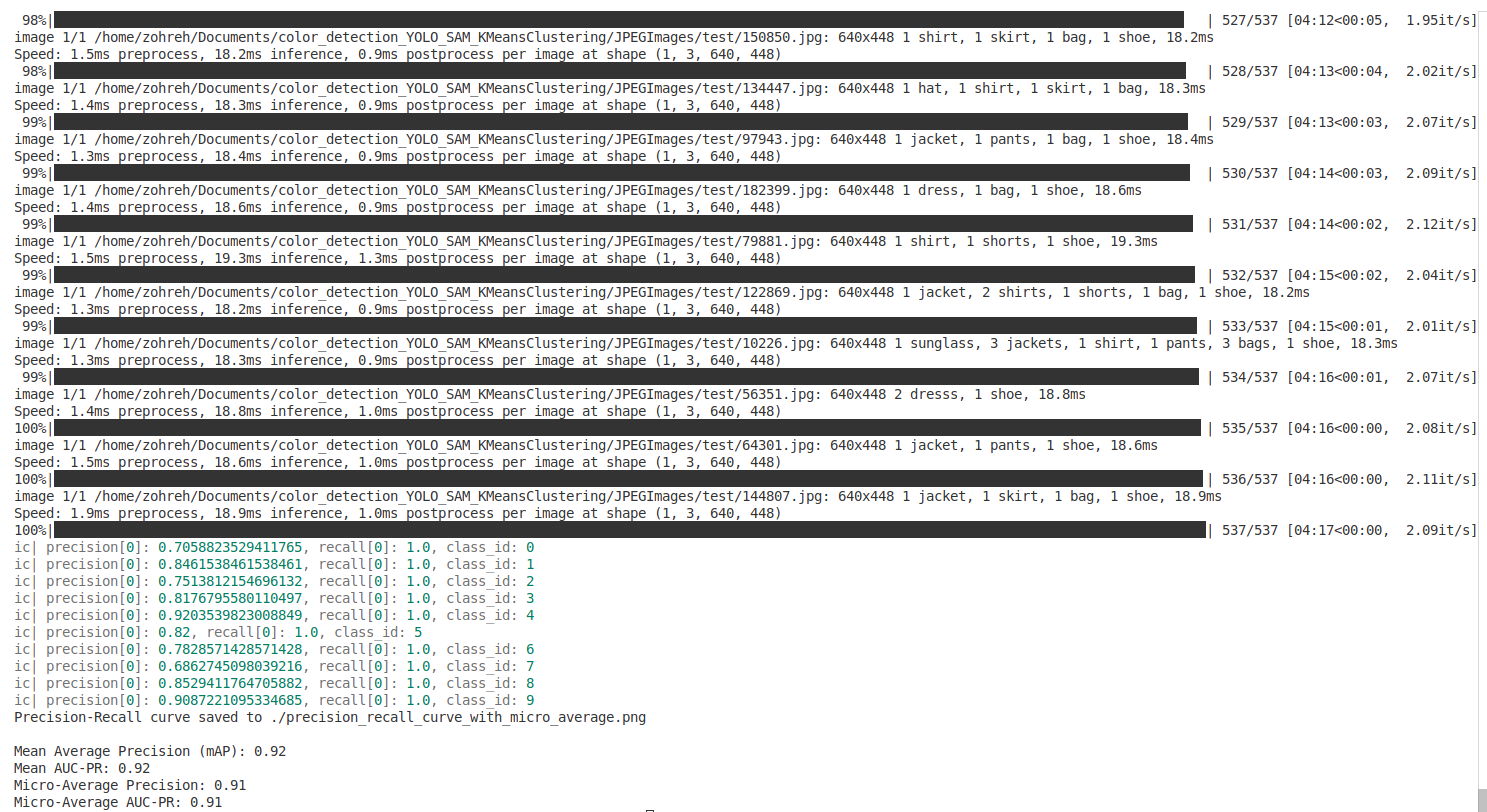

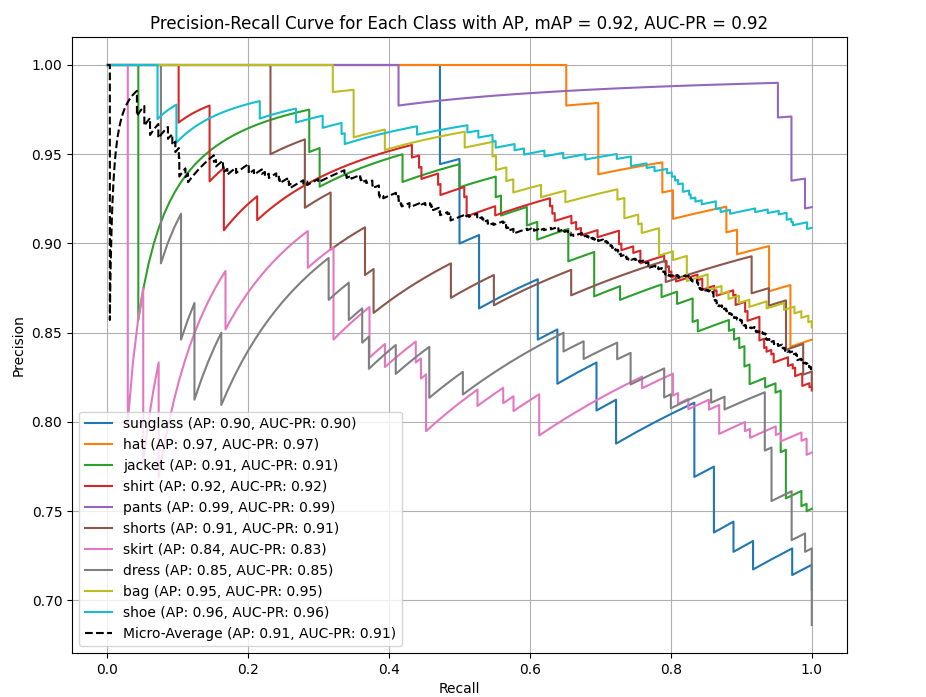

In [4]:
# this operation is computationally intensive and can not be executed on jupyter notbook, thus we run the code in terminal and saved screen shot of the result
from IPython.display import Image, display
display(Image(filename='/home/zohreh/Pictures/Screenshots/Screenshot from 2024-09-20 00-10-31.png'))

display(Image(filename='/home/zohreh/Pictures/Screenshots/Screenshot from 2024-09-20 00-04-04.png'))

First we calculate precision-recall curve.
As we can see, the AP (Average Precision) is the overall precision-recall trade-off. The higher the AP, the better the model’s overall ability to balance precision and recall for that class.

mAP= 0.92

AUC-PR = 0.92  (Area Under the Precision-Recall Curve). higher AUC-PR means the model performs better at maintaining precision as recall increases.

Micro-Average : This is a combined average of precision and recall across all classes. It shows the overall performance of the model when looking at all classes together. The micro-average curve is a good indicator of how the model is performing in general.

#### 3.1.1 graph of precisions across all classes when recall = 1

As we can see when recall = 1 means the model successfully predict all the objects in each class on the test set. There were no instances that the model missed . we get all precisions for all classes when recall = 1 in order to calculate percentage of all those positive predictions that are actually correct.

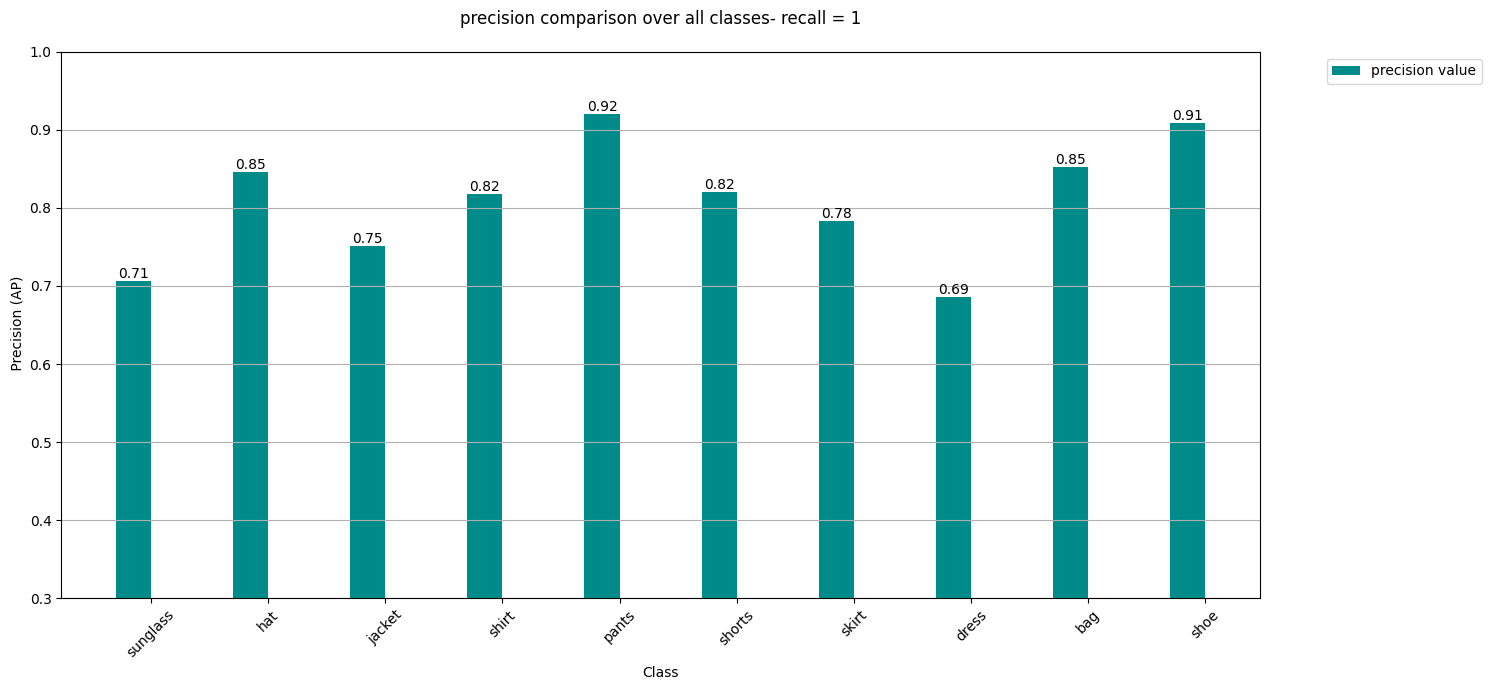

In [17]:

import matplotlib.pyplot as plt
import numpy as np

# Data for AP values
precision_values_when_recall_1 = {
    'sunglass': 0.7059,
    'hat': 0.8461 ,
    'jacket': 0.7513,
    'shirt': 0.8176 ,
    'pants': 0.9203,
    'shorts': 0.82 ,
    'skirt': 0.7828,
    'dress': 0.6862,
    'bag': 0.8529,
    'shoe': 0.9087 
}


# Extract class names and corresponding AP values for both cases
classes = list(precision_values_when_recall_1.keys())
precision_values = [precision_values_when_recall_1[cls] for cls in classes]



# Define bar width and positions
bar_width = 0.3
index = np.arange(len(classes))



# Create the bar plot
plt.figure(figsize=(15, 7))
bars1 = plt.bar(index, precision_values, bar_width, label='precision value', color='darkcyan')



# Add labels, title, and legend
plt.xlabel('Class')
plt.ylabel(' Precision (AP)')
plt.title('precision comparison over all classes- recall = 1', pad=20)
plt.xticks(index + bar_width / 2, classes, rotation=45)
plt.ylim(0.3, 1)  # Set the y-axis range to [0.3, 1] to fit all AP values
plt.grid(True, axis='y')



# Add numbers on the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')



# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
plt.tight_layout()  # Adjust layout to fit labels and title
plt.show()






Overall, the graph shows that the precision varies across classes:

with pants and shoe with the precision of 0.92 and 0.91 respectively, having the highest precision.

dress and sunglass with precision of 0.69 and  0.71 respectively, having the lowest precision.

#### 3.1.2 Calculate Accuracy of predicted clothing items based on Hungarian Matching Algorithm 

In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import glob
from tqdm import tqdm
import scipy.optimize




# keep track of correct and total detections both for per item and per image
def initialize_counters():
    return {
        'per_item_correct': torch.tensor(0, device='cuda'),
        'per_item_total': torch.tensor(0, device='cuda'),
        'per_image_correct': torch.tensor(0, device='cuda'),
        'per_image_total': torch.tensor(0, device='cuda')
    }



# Initialize counters for train, val, and test sets
train_counters = initialize_counters()
val_counters = initialize_counters()
test_counters = initialize_counters()

# Paths to the YOLO model checkpoint and image directories
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
jpeg_images_path = "JPEGImages"
train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")
best_weights_path = os.path.join(base_path, 'runs/detect/train/weights', 'best.pt')



# Function to convert class ID to label name
def class_to_label(class_id):
    classes = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
    return classes[class_id]




# Read annotations from text file
def read_txt_annotations(file_path):
    annots = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        elems = line.split()
        annots[int(elems[0])] = [float(elems[1]), float(elems[2]), float(elems[3]), float(elems[4])]
    return annots




# Convert YOLO bounding boxes from [cx, cy, w, h] to [x1, y1, x2, y2] format
def convert_whn_to_xyxy(box_whn, img_width, img_height):
    center_x, center_y, width, height = box_whn
    x_min = int((center_x - width / 2) * img_width)
    y_min = int((center_y - height / 2) * img_height)
    x_max = int((center_x + width / 2) * img_width)
    y_max = int((center_y + height / 2) * img_height)
    return [x_min, y_min, x_max, y_max]




# Computes the IoU between predicted and ground truth bounding boxes for evaluating detection accuracy
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[3], boxA[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou




# Matches detected objects with ground truth objects using the Hungarian algorithm based on IoU value
def find_all_gt_labels(final_items, annots, img_width, img_height):
    cost_matrix = []
    keys = list(annots.keys())

    for item in final_items:
        pred_box_xyxy = convert_whn_to_xyxy(item['box_xywhn'], img_width, img_height)
        
        ious = []
        for k in keys:
            gt_box_xyxy = convert_whn_to_xyxy(annots[k], img_width, img_height)
            ious.append(bb_intersection_over_union(pred_box_xyxy, gt_box_xyxy))
        
        cost_matrix.append(1 - np.array(ious))  # Minimizes the cost (1 - IoU) to assign each prediction to the best matching ground truth box
    
    # Perform Hungarian matching
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    
    # Assign best matching ground truth to each prediction
    matched_items = []
    for i, l in enumerate(col_ind):
        final_items[i]['gt_id'] = keys[l]
        final_items[i]['gt_label'] = class_to_label(keys[l])
        matched_items.append(final_items[i])
    
    return matched_items




# Detect objects using YOLO and apply Hungarian matching
def detect_and_match_objects(image_path, yolo_weights_path, counters):
    annotations_path = image_path.replace('.jpg', '.txt')
    annotations = read_txt_annotations(annotations_path)

    model = YOLO(yolo_weights_path).to('cuda')
    results = model(image_path)

    detected_items = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf.item()
            class_id = int(box.cls.item())
            label = model.names[class_id]
            detected_items.append({
                'label': label,
                'coordinates': [x1, y1, x2, y2],
                'confidence': confidence,
                'box_xywhn': box.xywhn[0].cpu().numpy().tolist(),
                'class_id': class_id
            })


    # Get image dimensions
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    final_items = find_all_gt_labels(detected_items, annotations, img_width, img_height)

    # Calculate accuracy
    per_image_not_correct = False
    for item in final_items:
        counters['per_item_total'] += 1
        if item['label'] == item['gt_label']:
            counters['per_item_correct'] += 1
        else:
            per_image_not_correct = True

    if not per_image_not_correct:
        counters['per_image_correct'] += 1

    counters['per_image_total'] += 1
    
    
    

# Accuracy calculation
def calculate_and_print_accuracy(counters, dataset_name):
    per_image_accuracy = counters['per_image_correct'].item() / counters['per_image_total'].item()
    per_item_accuracy = counters['per_item_correct'].item() / counters['per_item_total'].item()
    print(f'{dataset_name} - Per image accuracy: {per_image_accuracy:.4f}')
    print(f'{dataset_name} - Per item accuracy: {per_item_accuracy:.4f}')
    
    
    

# Run detection on the entire dataset
def process_all_images(image_paths, yolo_weights_path, counters):
    if not image_paths:
        print(f"No images found in dataset.")
        return
    for image_path in tqdm(image_paths):  # Process all images
        detect_and_match_objects(image_path, yolo_weights_path, counters)
        
        
        

# Process train, val, and test sets
def process_dataset():
    # Train Set
    print("\nProcessing Train Set...")
    train_files = glob.glob(os.path.join(train_image_path, '*.jpg'))
    process_all_images(train_files, best_weights_path, train_counters)
    calculate_and_print_accuracy(train_counters, "Train")

    # Validation Set
    print("\nProcessing Validation Set...")
    val_files = glob.glob(os.path.join(val_image_path, '*.jpg'))
    process_all_images(val_files, best_weights_path, val_counters)
    calculate_and_print_accuracy(val_counters, "Validation")

    # Test Set
    print("\nProcessing Test Set...")
    test_files = glob.glob(os.path.join(test_image_path, '*.jpg'))
    process_all_images(test_files, best_weights_path, test_counters)
    calculate_and_print_accuracy(test_counters, "Test")
    
    
    

# Run the process for all datasets
process_dataset()

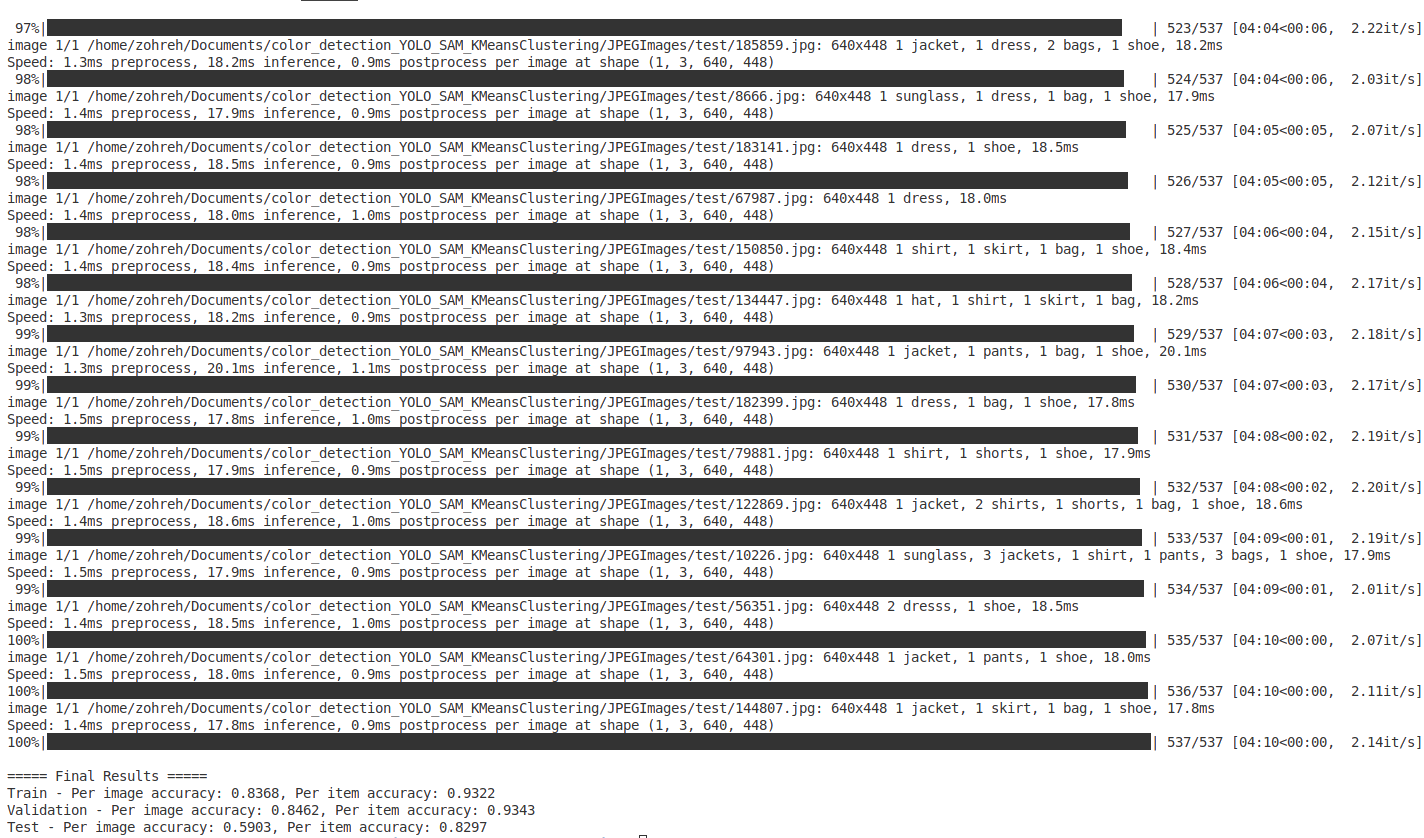

In [23]:
# this operation is computationaly intensive and can not be run in jupyter notbook, thus we run it in terminal and saved the result
from IPython.display import Image, display

display(Image(filename='/home/zohreh/Pictures/Screenshots/Screenshot from 2024-09-15 12-35-08.png'))


#### 3.1.2.1 graph for Accuracy per item and per image for train/validation/test set

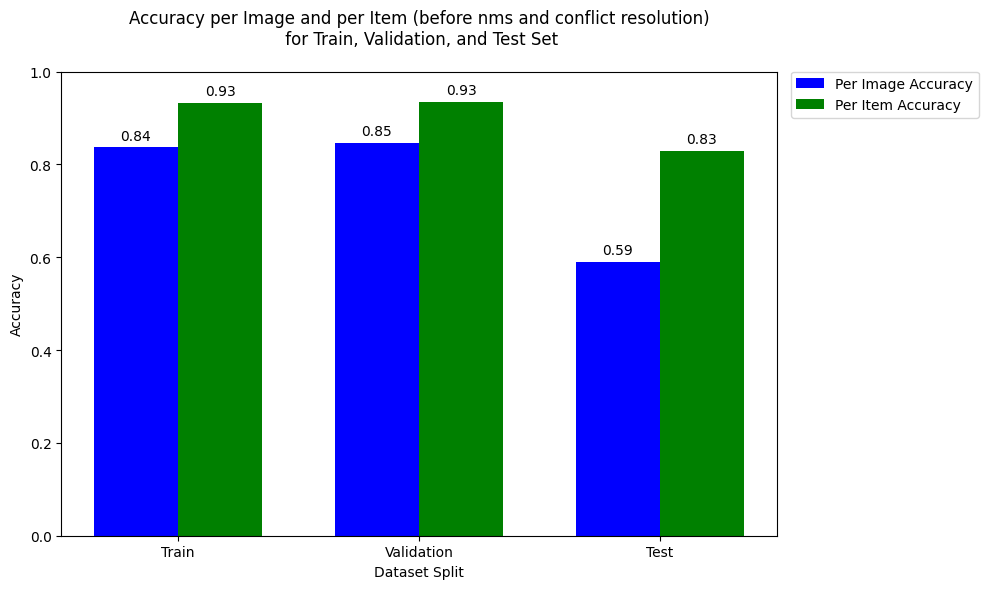

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define accuracy data
categories = ['Train', 'Validation', 'Test']
per_image_accuracy = [0.8368, 0.8462, 0.5903]
per_item_accuracy = [0.9322, 0.9343, 0.8297]

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(categories))

# Create the bar plot
plt.figure(figsize=(10, 6))
bars_image = plt.bar(index, per_image_accuracy, bar_width, label='Per Image Accuracy', color='blue')
bars_item = plt.bar(index + bar_width, per_item_accuracy, bar_width, label='Per Item Accuracy', color='green')

# Add labels and title
plt.xlabel('Dataset Split')
plt.ylabel('Accuracy')
plt.title('Accuracy per Image and per Item (before nms and conflict resolution)\n for Train, Validation, and Test Set' , pad=20)

plt.xticks(index + bar_width / 2, categories)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 since accuracy is a percentage

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# Add text labels on top of the bars
for bar in bars_image:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_item:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()


### 4. Identification of Issues

The test set shows an accuracy of 0.83 per item but only 0.59 per image. This means the model is good at detecting individual objects but struggles when there are 

multiple objects in an image.

To improve the per image accuracy, we need to focus on fixing cases where multiple conflicting items are detected together, such as when the model predicts items 

that can’t logically be worn together. This confusion leads to lower accuracy.








#### 4.1 Use Inference on the dataset to Visualize the detected clothing items for one sample from images


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/test/10226.jpg: 640x448 1 sunglass, 3 jackets, 1 shirt, 1 pants, 3 bags, 1 shoe, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


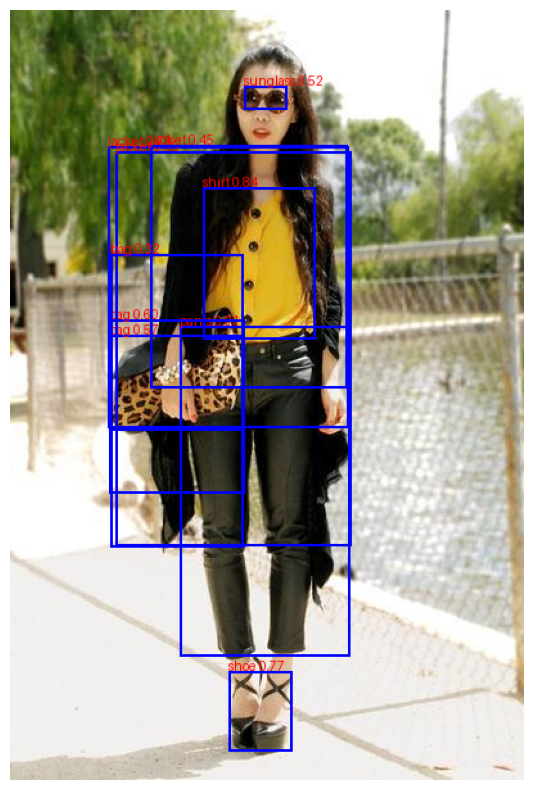

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO


# define the pathes
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")



train_file = os.path.join(image_sets_path, "trainval.txt")
test_file = os.path.join(image_sets_path, "test.txt")

#Load one sample image from the test set
sample_image_path = os.path.join(test_image_path, "10226.jpg")

image = Image.open(sample_image_path).convert('RGB')
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()


# path to the best weight from fine tuning yolov8 on our dataset
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train','weights')
best_weights_path = os.path.join(weights_save_path, "best.pt")



# define a function to draw bounding boxes predicted by yolo
def show_image_with_bbox(best_weights_path):
  
  # Load model and run inference
  model = YOLO(best_weights_path)
  results = model(sample_image_path)
  # print(results[0])
    
  for result in results:
    boxes = result.boxes

    for box in boxes:

      x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
      confidence = box.conf[0].item()         # Get confidence score
      class_id = int(box.cls[0])              # Get class id
      label = model.names[class_id]           # Get label for class id

      # Draw bounding box on the image
      draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
      
      # Put label and confidence score on the image
      draw.text((x1, y1 - 10), f"{label} {confidence:.2f}", fill="red", font=font)
      
      

  #Display the image with bounding boxes
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  
show_image_with_bbox(best_weights_path)



As we can see, there are multiple bboxes detected by model over the same object with different confidence scores.

To ensure more reliable results in later stages, such as segmentation and color detection, it's crucial to address and eliminate these overlapping and redundant
bounding boxes first. 

In order to retain bounding boxes with highest confidence score and discard the ones with lowest score, we use Non-Maximum-Suppression, which handle this situation

perfectly.

#### 4.2. Post-Processing-Non-Maximum-Suppression


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/test/10226.jpg: 640x448 1 sunglass, 3 jackets, 1 shirt, 1 pants, 3 bags, 1 shoe, 18.0ms
Speed: 1.5ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


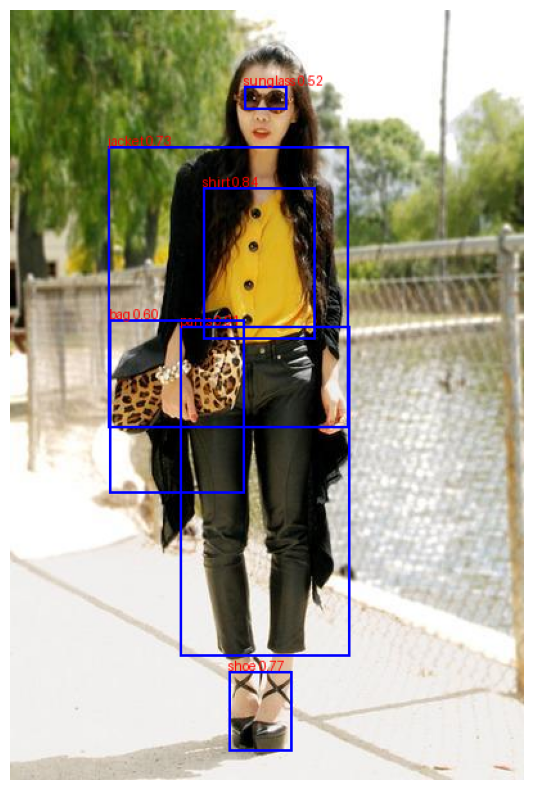

In [36]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms  # Import NMS from torchvision
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont


def detect_and_draw_nms_boxes(image_path, model_path, iou_threshold=0.5):
    
    """
    Detect objects in an image using a YOLO model, apply Non-Maximum Suppression (NMS),
    and draw the resulting bounding boxes on the image.

    Parameters:
    - image_path: Path to the image file.
    - model_path: Path to the YOLO model weights file.
    - iou_threshold: IoU threshold for NMS (default is 0.5).

    Returns:
    - image_with_boxes: Image with drawn bounding boxes after NMS.
    
    """
    # Load model and perform inference
    model = YOLO(best_weights_path)
    results = model(sample_image_path)
    
    # Load sample image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    # Prepare the data for NMS
    boxes_list = []
    scores_list = []
    labels_list = []
    
    for result in results:
        boxes = result.boxes                        #list of dictionries containing(xysy, conf, cls)
        for box in boxes:                           # extract the box object from the result
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            confidence = box.conf[0].item()         # Get confidence score
            class_id = int(box.cls[0])              # Get class id
            label = model.names[class_id]           # Get label for class id

            boxes_list.append([x1, y1, x2, y2])
            scores_list.append(confidence)
            labels_list.append(class_id)
            
    # Convert to tensors for applying NMS
    boxes_tensor = torch.tensor(boxes_list, dtype=torch.float32)
    scores_tensor = torch.tensor(scores_list, dtype=torch.float32)
    
    #Perform Non-Maximum Suppression (NMS)
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    
     # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels_list[i] for i in nms_indices]
    
    
     # Draw the best bounding boxes on the image
    for i, box in enumerate(nms_boxes):
        x1, y1, x2, y2 = map(int, box)
        confidence = nms_scores[i]
        label = model.names[nms_labels[i]]

        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), f"{label} {confidence:.2f}", fill="red", font=font)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image

             

# path to annotations and images
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

train_file = os.path.join(image_sets_path, "trainval.txt")
test_file = os.path.join(image_sets_path, "test.txt")

# Load sample image
sample_image_path = os.path.join(test_image_path, "10226.jpg")
image = Image.open(sample_image_path).convert('RGB')
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# path to best weight from finetuning model
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
best_weights_path = os.path.join(weights_save_path, "best.pt")


#call the function
image_with_nms_boxes = detect_and_draw_nms_boxes(sample_image_path, best_weights_path, iou_threshold=0.5)


As we see after post-processing with NMS, image shows cleaner and more precise detections, making it suitable for later tasks like segmentation and color detection.

### 4.2.1 Use Inference on the dataset considering NMS logic, for further exploring issues


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/13689.jpg: 640x448 1 shirt, 1 dress, 1 shoe, 18.2ms
Speed: 1.5ms preprocess, 18.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


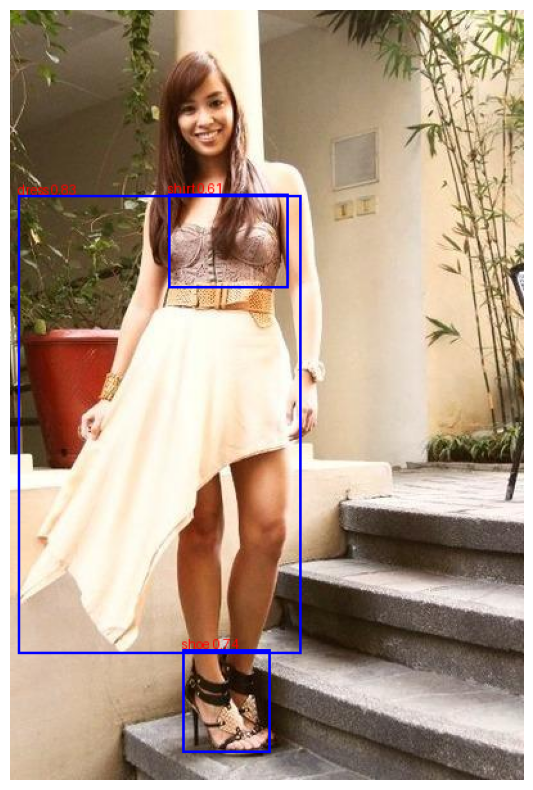

In [37]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms  # Import NMS from torchvision
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont


def detect_and_draw_nms_boxes(image_path, model_path, iou_threshold=0.5):
    
    """
    Detect objects in an image using a YOLO model, apply Non-Maximum Suppression (NMS),
    and draw the resulting bounding boxes on the image.

    Parameters:
    - image_path: Path to the image file.
    - model_path: Path to the YOLO model weights file.
    - iou_threshold: IoU threshold for NMS (default is 0.5).

    Returns:
    - image_with_boxes: Image with drawn bounding boxes after NMS.
    
    """
    # Load model and perform inference
    model = YOLO(best_weights_path)
    results = model(sample_image_path)
    
    # Load sample image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    # Prepare the data for NMS
    boxes_list = []
    scores_list = []
    labels_list = []
    
    for result in results:
        boxes = result.boxes  #list of dictionries containing(xysy, conf, cls)
        for box in boxes: # extract the box object from the result
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            confidence = box.conf[0].item()  # Get confidence score
            class_id = int(box.cls[0])  # Get class id
            label = model.names[class_id]  # Get label for class id

            boxes_list.append([x1, y1, x2, y2])
            scores_list.append(confidence)
            labels_list.append(class_id)
            
            
    # Convert to tensors for NMS
    boxes_tensor = torch.tensor(boxes_list, dtype=torch.float32)
    scores_tensor = torch.tensor(scores_list, dtype=torch.float32)
    
    
    #Perform Non-Maximum Suppression (NMS)
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    
     # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels_list[i] for i in nms_indices]
    
    
     # Draw the best bounding boxes on the image
    for i, box in enumerate(nms_boxes):
        x1, y1, x2, y2 = map(int, box)
        confidence = nms_scores[i]
        label = model.names[nms_labels[i]]

        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), f"{label} {confidence:.2f}", fill="red", font=font)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image

            
    

# path to images and annotations
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

train_file = os.path.join(image_sets_path, "trainval.txt")
test_file = os.path.join(image_sets_path, "test.txt")

# Load sample image
sample_image_path = os.path.join(train_image_path, "13689.jpg")
image = Image.open(sample_image_path).convert('RGB')
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# path to best weight from fine-tuning model on dataset
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
best_weights_path = os.path.join(weights_save_path, "best.pt")


#call the function
image_with_nms_boxes = detect_and_draw_nms_boxes(sample_image_path, best_weights_path, iou_threshold=0.5)

in this image there are two items detected by model. shirt and dress. we know these items can not be worn by a person at the same time. so we need to provide a dictionary of conflicting items and we need to resolve this issue .

The conflict resolution step in this code aims to remove logically inconsistent items from the final object detection results. The logic is based on the 
assumption that certain clothing items cannot be worn together simultaneously, such as wearing a skirt and pants at the same time or dress and shirt. To address this, a conflict resolution logic is implemented to filter out conflicting detections based on their confidence scores

### 4.2.2 Post-Processing (Conflict Resolution)


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/JPEGImages/train/13689.jpg: 640x448 1 shirt, 1 dress, 1 shoe, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


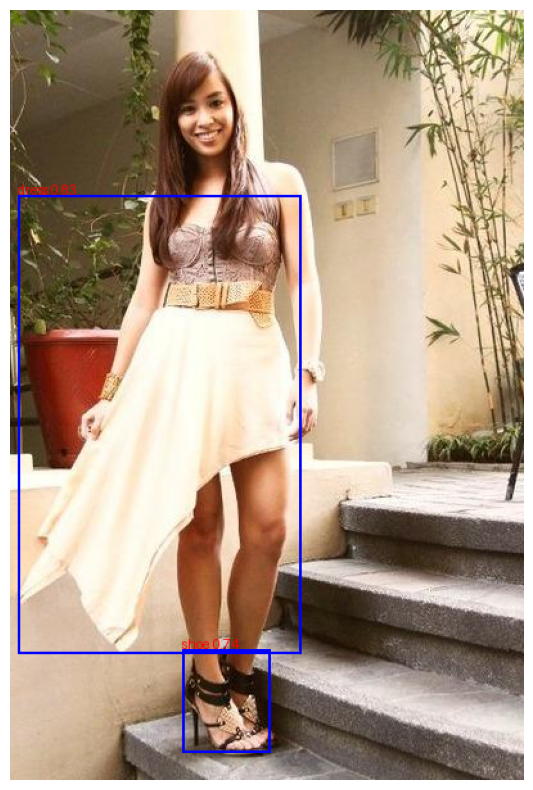

In [21]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms  # Import NMS from torchvision
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont


def detect_and_draw_nms_boxes(image_path, model_path, iou_threshold=0.5):
    """
    Detect objects in an image using a YOLO model, apply Non-Maximum Suppression (NMS),
    apply conflict resolution, and draw the resulting bounding boxes on the image.

    Parameters:
    - image_path: Path to the image file.
    - model_path: Path to the YOLO model weights file.
    - iou_threshold: IoU threshold for NMS (default is 0.5).

    Returns:
    - image_with_boxes: Image with drawn bounding boxes after NMS and conflict resolution.
    """
    # Load model and perform inference
    model = YOLO(model_path)
    results = model(image_path)

    # Load sample image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    # Prepare the data for NMS
    detected_items = []

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            confidence = box.conf.item()  # Get confidence score
            class_id = int(box.cls.item())  # Get class id
            label = model.names[class_id]  # Get label for class id

            detected_items.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': confidence,
                'label': label,
                'class_id': class_id
            })

    # Convert to tensors for NMS
    boxes_tensor = torch.tensor([item['bbox'] for item in detected_items], dtype=torch.float32)
    scores_tensor = torch.tensor([item['confidence'] for item in detected_items], dtype=torch.float32)

    # Perform Non-Maximum Suppression (NMS)
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    # Filter the detected items based on NMS output
    nms_filtered_items = [detected_items[i] for i in nms_indices]

    # Apply conflict resolution on the filtered items
    final_items = conflict_resolution(nms_filtered_items)
    
    
    
    # Draw the final bounding boxes on the image after conflict resolution
    for item in final_items:
        x1, y1, x2, y2 = item['bbox']
        confidence = item['confidence']
        label = item['label']

        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), f"{label} {confidence:.2f}", fill="red", font=font)
        

    # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image



# conflict resolution function
def conflict_resolution(items):
    final_items = []
    items_dict = {}                           # each detected items is stored in items_dict dictionary
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'],
                                     'idx': i}


# A predefined dictionary conflicts specifies which clothing items conflict with each other

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }
    
#for each item in items_dict, if its label is in the conflicts dictionary, it checks for other items that have conflicting labels.
    conflict_pairs = []   
    for k in items_dict.keys():   
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))  # pair of conflicting items will be added to conflict_pairs dictionary
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []
    

# resolves conflicts by comparing the confidence scores of the conflicting items. The item with the higher confidence is kept, and the item with the lower confidence is discarded.
#if neither item in a conflicting pair is already present in the final list (winners), the one with the higher confidence is added to final_items.

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items




# path to images and annotations
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
annotations_path = "Annotations"
annotations_txt_path = "Annotations_txt"
image_sets_path = "ImageSets/Main"
jpeg_images_path = "JPEGImages"

train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

train_file = os.path.join(image_sets_path, "trainval.txt")
test_file = os.path.join(image_sets_path, "test.txt")

# Load sample image
sample_image_path = os.path.join(train_image_path, "13689.jpg")


# pathes to best weights from fine-tuning with yolo
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
best_weights_path = os.path.join(weights_save_path, "best.pt")

# Call the function
image_with_nms_boxes = detect_and_draw_nms_boxes(sample_image_path, best_weights_path, iou_threshold=0.5)

This process is to ensure the model does not detect clothing items that are conflicting with each other. For instance, if the model detects a “dress” and a “shirt” separately, we remove the one that has a lower confidence, since a person cannot wear a dress and a shirt at the same time

### 5.Evaluate the model on the test set with(Precision-Recall Curve) and calculate Accuracy on train/val/test after Post-Processing

In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms  # Import NMS from torchvision
from ultralytics import YOLO
from PIL import Image, ImageDraw
import glob
from tqdm import tqdm
import scipy.optimize
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from icecream import ic  # Importing the icecream library



# path to the images
base_path = '/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering'
train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")


# Initialize SAM2 model
checkpoint = os.path.join(base_path, "segment-anything-2/checkpoints/sam2_hiera_large.pt")
model_cfg = "sam2_hiera_l.yaml"
sam_model = build_sam2(model_cfg, checkpoint).to('cuda')  # Move SAM model to GPU
mask_predictor = SAM2ImagePredictor(sam_model)  # Initialize the SAM2ImagePredictor


# Initialize performance counters
def initialize_counters():
    return {
        'per_item_correct': torch.tensor(0, device='cuda'),
        'per_item_total': torch.tensor(0, device='cuda'),
        'per_image_correct': torch.tensor(0, device='cuda'),
        'per_image_total': torch.tensor(0, device='cuda')
    }

train_counters = initialize_counters()
val_counters = initialize_counters()
test_counters = initialize_counters()

# path to the images
jpeg_images_path = "JPEGImages"
train_image_path = os.path.join(jpeg_images_path, "train")
val_image_path = os.path.join(jpeg_images_path, "val")
test_image_path = os.path.join(jpeg_images_path, "test")

annotations_path = "Annotations"


# Paths to the YOLO model checkpoint and image directories
runs_path = os.path.join(base_path, 'runs', 'detect')
weights_save_path = os.path.join(runs_path, 'train', 'weights')
best_weights_path = os.path.join(weights_save_path, "best.pt")



# function for inference yolo on dataset, then apply NMS , Apply conflict resolution to get finall items
def detect_and_draw_nms_boxes(image_path, model_path, iou_threshold=0.5):
    model = YOLO(model_path).to('cuda')  # Move YOLO model to GPU
    results = model(image_path)
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)

    detected_items = []   # detected items by yolo is added to detected_items list

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf.item()
            class_id = int(box.cls.item())
            label = model.names[class_id]

            detected_items.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': confidence,
                'label': label,
                'class_id': class_id
            })
        

    boxes_tensor = torch.tensor([item['bbox'] for item in detected_items], dtype=torch.float32, device='cuda')
    scores_tensor = torch.tensor([item['confidence'] for item in detected_items], dtype=torch.float32, device='cuda')
    
    # apply nms on detected boxes
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)
    nms_filtered_items = [detected_items[i] for i in nms_indices]
    
    
    # apply conflict_resolution on items that filtered by nms
    final_items = conflict_resolution(nms_filtered_items)

    for item in final_items:
        x1, y1, x2, y2 = item['bbox']
        confidence = item['confidence']
        label = item['label']

        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y1 - 10), f"{label} {confidence:.2f}", fill="red")

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image


# define conflict resolution function/in order to resolve conflict between items
def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items



# function to read annotations from files
def read_txt_annotations(file_path):
    annots = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        elems = line.split('\n')[0].split(' ')
        annots[int(elems[0])] = [float(elems[1]), float(elems[2]), float(elems[3]), float(elems[4])]
    return annots




#this function calculates the Intersection over Union (IoU) for two bounding boxes given in the [x1, y1, x2, y2] format.
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])                                         # calculate the coordinates of the intersection
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[3], boxA[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)              # calculate the area  of intersection
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)       # calculate the area of both boxes
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)           # This value is between 0 (no overlap) and 1 (complete overlap)
    return iou



# step to convert Cx, Cy, w, h into format  x,1, y1, x2, y2 and apply bb_intersection_over_union to return iou 
def iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    bbox1_xyxy = np.array([x1 - w1, y1 - h1, x1 + w1, y1 + h1])
    bbox2_xyxy = np.array([x2 - w2, y2 - h2, x2 + w2, y2 + h2])
    iou_value = bb_intersection_over_union(bbox1_xyxy, bbox2_xyxy)
    return iou_value




def class_to_label(class_id):
    classes = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
    return classes[class_id]



# define hungarian matching algorithm
def find_all_gt_labels(final_items, annots, model):
    new_final_items = []
    cost_matrix = []
    keys = list(annots.keys())
    class_ids = []
    for item in final_items:
        class_id = item['class_id']
        class_ids.append(class_id)
        
        ious = []
        for k in keys:
            ious.append(iou(annots[k], item['box_xywhn']))
        cost_matrix.append(ious)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix=cost_matrix, maximize=True)
   
    for i, l in enumerate(col_ind):
        final_items[i]['gt_id'] = keys[l]
        final_items[i]['gt_label'] = class_to_label(keys[l])
        new_final_items.append(final_items[i])
    
    return new_final_items



# define function for run inference with yolo and generate segmentation masks with sam 
def detect_and_segment_objects(base_path, sub_folder, segmented_images_dir, image_path, yolo_weights_path, counters):
    orig_filename = os.path.basename(image_path)
    annotations_path = image_path.split('.jpg')[0] + '.txt'
    annotations = read_txt_annotations(annotations_path)

    model = YOLO(yolo_weights_path).to('cuda')

    image = Image.open(image_path).convert('RGB')
    image_rgb = np.array(image)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    results = model(image_path)

    detected_items = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  
            confidence = box.conf[0].item()  
            class_id = int(box.cls[0])  
            label = model.names[class_id]  
            detected_items.append({
                'label': label,
                'coordinates': (x1, y1, x2, y2),
                'confidence': confidence,
                'box_xywhn': box.xywhn[0].cpu().numpy().tolist(),
                'class_id': class_id
            })

    boxes_tensor = torch.tensor([item['coordinates'] for item in detected_items], dtype=torch.float32, device='cuda')
    scores_tensor = torch.tensor([item['confidence'] for item in detected_items], dtype=torch.float32, device='cuda')
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)
    nms_filtered_items = [detected_items[i] for i in nms_indices]

    final_items = conflict_resolution(nms_filtered_items)
    final_items = find_all_gt_labels(final_items, annotations, model)

    predicted_boxes = []
    labels = []
    gt_labels = []

    mask_predictor.set_image(image_bgr)

    for item in final_items:
        predicted_boxes.append(item['coordinates'])
        labels.append(item['label'])
        gt_labels.append(item['gt_label'])

    per_image_not_correct = False
    for i, l in enumerate(labels):
        counters['per_item_total'] += 1
        if gt_labels[i] == l:
            counters['per_item_correct'] += 1
        else:
            per_image_not_correct = True

    if not per_image_not_correct:
        counters['per_image_correct'] += 1

    counters['per_image_total'] += 1

    predicted_boxes = np.array(predicted_boxes)
    masks, scores, _ = mask_predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=predicted_boxes[None, :],
                        multimask_output=False,
    )

    save_path_orig_filename = os.path.join(segmented_images_dir, orig_filename)
    orig_image = Image.fromarray(image_rgb)
    orig_image.save(save_path_orig_filename)

    for i, mask in enumerate(masks):
        mask = mask[0].astype(np.uint8)  

        mask_image = Image.fromarray(mask * 255)  
        mask_filename = os.path.join(segmented_images_dir, orig_filename.split('.')[0] + f'_mask_yolo_{labels[i]}_gt_{gt_labels[i]}.png')
        mask_image.save(mask_filename)
        
        

def process_dataset(image_paths, segmented_images_dir, yolo_weights_path, counters):
    os.makedirs(segmented_images_dir, exist_ok=True)
    for image_path in tqdm(image_paths):
        detect_and_segment_objects(base_path, sub_folder, segmented_images_dir, image_path, yolo_weights_path, counters)

# Process training set
sub_folder = 'train'
train_files = glob.glob(os.path.join(train_image_path, '*.jpg'))
segmented_train_dir = os.path.join(base_path, "segmented_images", sub_folder)
process_dataset(train_files, segmented_train_dir, best_weights_path, train_counters)

# Process validation set
sub_folder = 'val'
val_files = glob.glob(os.path.join(val_image_path, '*.jpg'))
segmented_val_dir = os.path.join(base_path, "segmented_images", sub_folder)
process_dataset(val_files, segmented_val_dir, best_weights_path, val_counters)

# Process test sets
sub_folder = 'test'
test_files = glob.glob(os.path.join(test_image_path, '*.jpg'))
segmented_test_dir = os.path.join(base_path, "segmented_images", sub_folder)
process_dataset(test_files, segmented_test_dir, best_weights_path, test_counters)

# Calculate and print accuracy for train, val, and test sets
def calculate_and_print_accuracy(counters, dataset_name):
    per_image_accuracy = counters['per_image_correct'].item() / counters['per_image_total'].item()
    per_item_accuracy = counters['per_item_correct'].item() / counters['per_item_total'].item()
    print(f'{dataset_name} - Per image accuracy: {per_image_accuracy:.4f}')
    print(f'{dataset_name} - Per item accuracy: {per_item_accuracy:.4f}')

calculate_and_print_accuracy(train_counters, "Train")
calculate_and_print_accuracy(val_counters, "Validation")
calculate_and_print_accuracy(test_counters, "Test")

### 5.1. The result of using Non-Maximum Suppression/ Resolved Conflict / Hungarian Algorithm

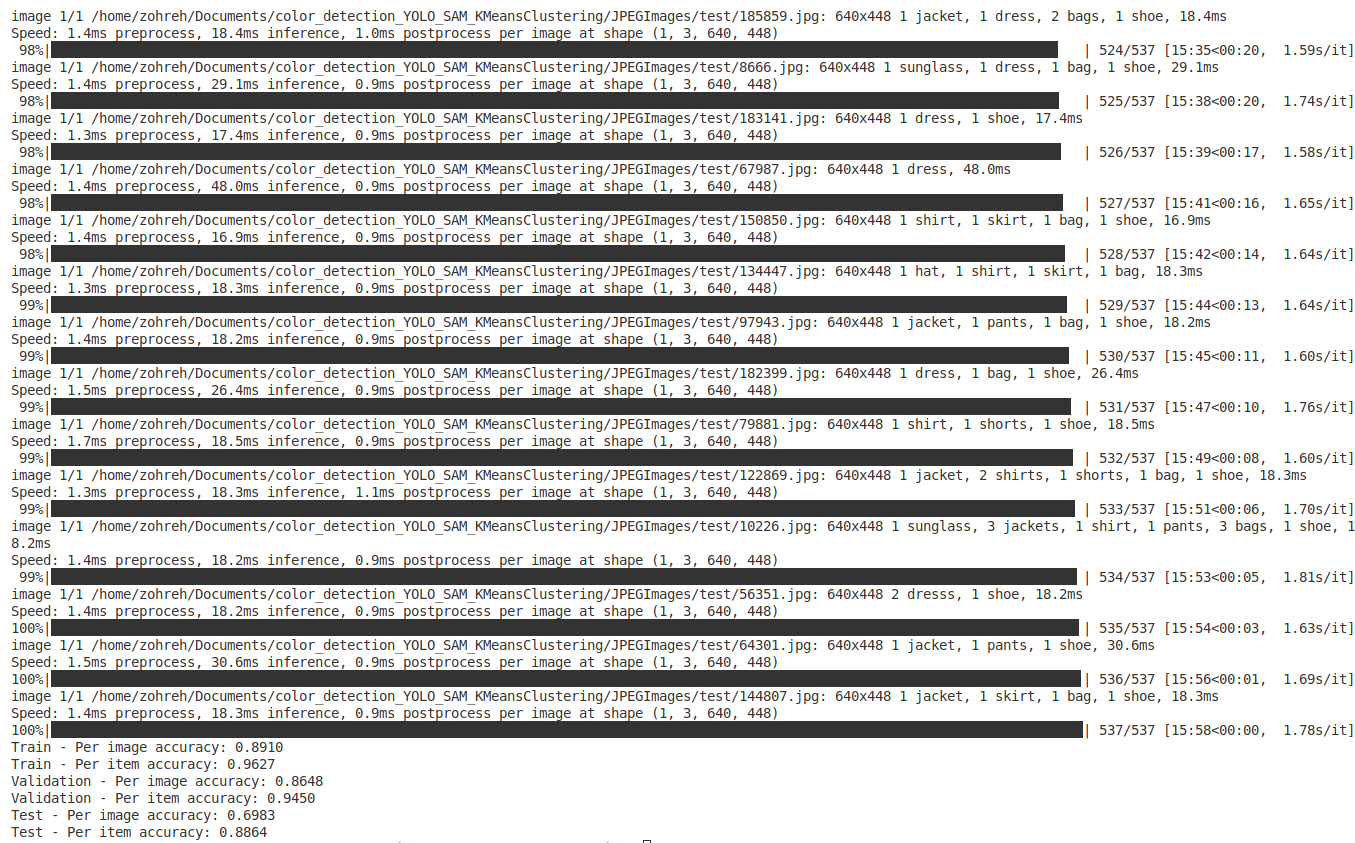

In [2]:
# the previous code is computationaly intensive and can not be run in jupyter notebook, hence we run it in terminal and saved the result and graph

from IPython.display import Image, display

display(Image(filename='/home/zohreh/Pictures/Screenshots/Screenshot from 2024-08-30 07-20-09.png'))


### 5.2. Graph for Accuracy per item and per image for test and validation set

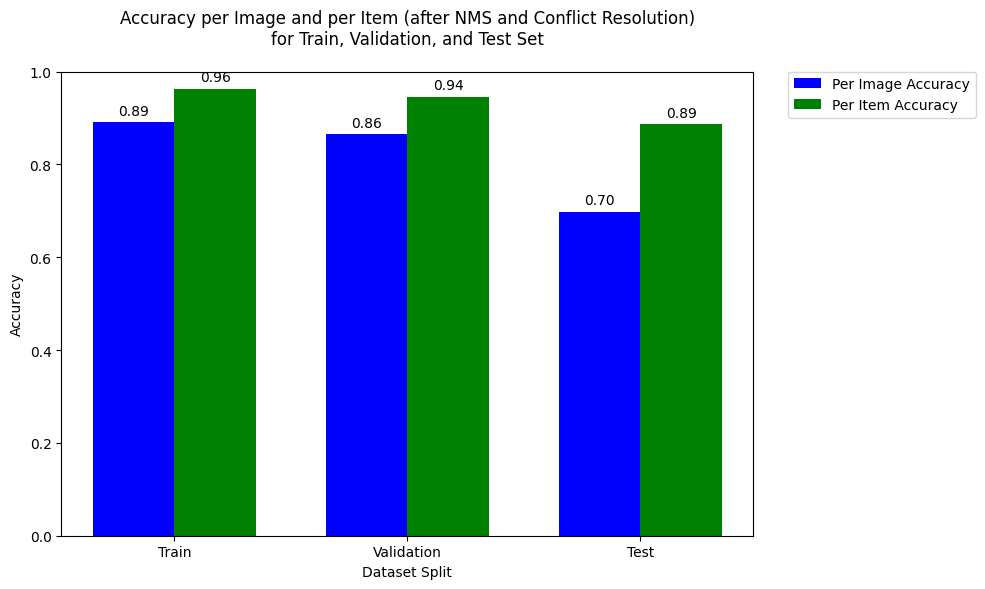

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define accuracy data
categories = ['Train', 'Validation', 'Test']
per_image_accuracy = [0.8910, 0.8648, 0.6983]
per_item_accuracy = [0.9627, 0.9450, 0.8864]

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(categories))

# Create the bar plot
plt.figure(figsize=(10, 6))
bars_image = plt.bar(index, per_image_accuracy, bar_width, label='Per Image Accuracy', color='blue')
bars_item = plt.bar(index + bar_width, per_item_accuracy, bar_width, label='Per Item Accuracy', color='green')

# Add labels and title
plt.xlabel('Dataset Split')
plt.ylabel('Accuracy')
plt.title('Accuracy per Image and per Item (after NMS and Conflict Resolution)\nfor Train, Validation, and Test Set', pad=20)  # Add space with pad
plt.xticks(index + bar_width / 2, categories)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 since accuracy is a percentage

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add text labels on top of the bars
for bar in bars_image:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars_item:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

as we see  in bar chart, per item accuracy  is 0.89 and per image accuracy is 0.70. in comparison with the result from baseline model(before preprocessing), the model predict better after post processing.

### 5.3. Percision-Recall Curve (PRC) and AUC-PR

Precision measures the proportion of true positive detections out of all detections made by the model, i.e., how many of the detected objects are actually relevant.


Recall measures the proportion of true positive detections out of all actual objects in the ground truth, i.e., how many of the relevant objects were detected.


AUC-PR is the Area Under the Precision-Recall Curve. It provides a single number summarizing the trade-off between precision and recall across different thresholds.

Mean Average Percision(mAP)

mAP is one of the most commonly used metrics in object detection. It calculates the average precision (AP) for each class and then averages them to produce a single metric.

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms
from ultralytics import YOLO
from PIL import Image
import glob
from tqdm import tqdm
import scipy.optimize
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from icecream import ic

# Initialize counters for precision-recall
def initialize_pr_data(num_classes):
    return {
        'true_labels': [[] for _ in range(num_classes)],
        'confidences': [[] for _ in range(num_classes)],
        'global_true_labels': [],
        'global_confidences': []
    }

# Paths to the YOLO model checkpoint and image directories
base_path = "./"
jpeg_images_path = "JPEGImages"
test_image_path = os.path.join(jpeg_images_path, "test")
best_weights_path = os.path.join(base_path, 'runs/detect/train/weights', 'best.pt')
# best_weights_path = os.path.join(base_path, 'best.pt')



# Function to convert class ID to label name
def class_to_label(class_id):
    classes = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
    return classes[class_id], len(classes)

# Read annotations from text file
def read_txt_annotations(file_path):
    annots = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        elems = line.split()
        annots[int(elems[0])] = [float(elems[1]), float(elems[2]), float(elems[3]), float(elems[4])]
    return annots

# Convert YOLO bounding boxes from [cx, cy, w, h] to [x1, y1, x2, y2] format
def convert_whn_to_xyxy(box_whn, img_width, img_height):
    center_x, center_y, width, height = box_whn
    x_min = int((center_x - width / 2) * img_width)
    y_min = int((center_y - height / 2) * img_height)
    x_max = int((center_x + width / 2) * img_width)
    y_max = int((center_y + height / 2) * img_height)
    return [x_min, y_min, x_max, y_max]

# IoU calculation
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[3], boxA[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Conflict resolution function
def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i,item in enumerate(items):
        items_dict[item['label']] = {'confidence': item['confidence'],
                                     'idx': i}
        
    classes = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
    
    conflicts = {'shirt': ['dress'],
                 'pants': ['shorts','skirt'],
                 'shorts': ['pants', 'skirt'],
                 'skirt' : ['pants', 'shorts'],
                 'dress' : ['shirt']
                 }
    
    conflict_pairs = []
    for k in items_dict.keys():
        if k in ['sunglass', 'hat', 'jacket', 'bag', 'shoe']:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k,conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])
    
    for i,pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        elif items_dict[pair[1]]['confidence'] > items_dict[pair[0]]['confidence']:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items
# Hungarian matching and ground truth association
def find_all_gt_labels(final_items, annots, img_width, img_height):
    cost_matrix = []
    keys = list(annots.keys())

    for item in final_items:
        pred_box_xyxy = convert_whn_to_xyxy(item['box_xywhn'], img_width, img_height)
        
        ious = []
        for k in keys:
            gt_box_xyxy = convert_whn_to_xyxy(annots[k], img_width, img_height)
            ious.append(bb_intersection_over_union(pred_box_xyxy, gt_box_xyxy))
        
        cost_matrix.append(1 - np.array(ious))  # We want to minimize 1 - IoU
    
    # Perform Hungarian matching
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
    
    # Assign best matching ground truth to each prediction
    matched_items = []
    for i, l in enumerate(col_ind):
        final_items[i]['gt_id'] = keys[l]
        final_items[i]['gt_label'] = class_to_label(keys[l])[0]
        matched_items.append(final_items[i])
    
    return matched_items

# Detect objects using YOLO, apply NMS, conflict resolution, and Hungarian matching
def detect_and_match_objects(image_path, yolo_weights_path, pr_data, num_classes):
    annotations_path = image_path.replace('.jpg', '.txt')
    annotations = read_txt_annotations(annotations_path)

    model = YOLO(yolo_weights_path).to('cuda')
    results = model(image_path, verbose=False)

    detected_items = []
    for result in results:
        for box in result.boxes:
            confidence = box.conf.item()
            class_id = int(box.cls.item())
            label = class_to_label(class_id)[0]
            detected_items.append({
                'confidence': confidence,
                'box_xywhn': box.xywhn[0].cpu().numpy().tolist(),
                'class_id': class_id,
                'label': label
            })

    # Get image dimensions
    img = Image.open(image_path)
    img_width, img_height = img.size

    # Apply NMS
    boxes_tensor = torch.tensor([convert_whn_to_xyxy(item['box_xywhn'], img_width, img_height) for item in detected_items], dtype=torch.float32)
    scores_tensor = torch.tensor([item['confidence'] for item in detected_items], dtype=torch.float32)
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)
    nms_filtered_items = [detected_items[i] for i in nms_indices]

    # Apply conflict resolution
    final_items = conflict_resolution(nms_filtered_items)
    # final_items = nms_filtered_items

    # Perform Hungarian matching between predictions and ground truth
    final_items = find_all_gt_labels(final_items, annotations, img_width, img_height)

    # Update precision-recall data
    for item in final_items:
        class_id = item['class_id']
        confidence = item['confidence']
        gt_label = item['gt_label']

        pr_data['confidences'][class_id].append(confidence)
        pr_data['true_labels'][class_id].append(1 if class_to_label(class_id)[0] == gt_label else 0)

        # Update global precision-recall data for micro-average
        pr_data['global_confidences'].append(confidence)
        pr_data['global_true_labels'].append(1 if class_to_label(class_id)[0] == gt_label else 0)

# Plot Precision-Recall curve, including micro-average PR curve and calculate mAP
def plot_pr_curve_and_auc(pr_data, num_classes):
    plt.figure(figsize=(10, 8))
    ap_per_class = {}
    auc_per_class = {}
    aps = []

    for class_id in range(num_classes):
        if len(pr_data['true_labels'][class_id]) == 0:
            continue

        precision, recall, _ = precision_recall_curve(pr_data['true_labels'][class_id], pr_data['confidences'][class_id])
        ic(precision[0], recall[0], class_id)
        ap = average_precision_score(pr_data['true_labels'][class_id], pr_data['confidences'][class_id])
        pr_auc = auc(recall, precision)

        ap_per_class[class_to_label(class_id)[0]] = ap
        auc_per_class[class_to_label(class_id)[0]] = pr_auc
        aps.append(ap)  # Collect AP for mAP calculation

        plt.plot(recall, precision, label=f"{class_to_label(class_id)[0]} (AP: {ap:.2f}, PR-AUC: {pr_auc:.2f})")

    # Calculate mean average precision (mAP)
    mAP = np.mean(aps)

    # Calculate micro-average precision-recall
    global_precision, global_recall, _ = precision_recall_curve(pr_data['global_true_labels'], pr_data['global_confidences'])
    micro_ap = average_precision_score(pr_data['global_true_labels'], pr_data['global_confidences'])
    micro_pr_auc = auc(global_recall, global_precision)

    plt.plot(global_recall, global_precision, color='black', linestyle='--', label=f"Micro-Average (AP: {micro_ap:.2f}, PR-AUC: {micro_pr_auc:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Each Class with AP, PR-AUC, and mAP = {mAP:.2f}')
    plt.legend(loc='lower left')
    plt.grid(True)

    # Save the plot to a file
    # plot_file_path = os.path.join(base_path, "precision_recall_curve_with_ap_and_pr_auc_with_mAP_no_conflict_resolution.png")
    plot_file_path = os.path.join(base_path, "precision_recall_curve_with_ap_and_pr_auc_with_mAP.png")
    plt.savefig(plot_file_path)
    print(f"Precision-Recall curve saved to {plot_file_path}")

    # Print AP, PR-AUC for each class, and mAP
    print("\nAverage Precision (AP) and PR-AUC per class:")
    for class_name in ap_per_class.keys():
        print(f"{class_name}: AP = {ap_per_class[class_name]:.2f}, PR-AUC = {auc_per_class[class_name]:.2f}")

    # Print mAP and micro-average results
    print(f"\nMean Average Precision (mAP): {mAP:.2f}")
    print(f"Micro-Average: AP = {micro_ap:.2f}, PR-AUC = {micro_pr_auc:.2f}")

# Run detection on the entire test set
def process_test_set():
    # Get number of classes
    _, num_classes = class_to_label(0)
    
    # Initialize PR data for each class
    pr_data = initialize_pr_data(num_classes)

    # Test Set
    test_files = glob.glob(os.path.join(test_image_path, '*.jpg'))

    # Process all test images
    for i, image_path in enumerate(tqdm(test_files)):
        
        detect_and_match_objects(image_path, best_weights_path, pr_data, num_classes)

    # Plot Precision-Recall Curve, calculate AUC, mAP
    plot_pr_curve_and_auc(pr_data, num_classes)

# Run the process for the test dataset
process_test_set()


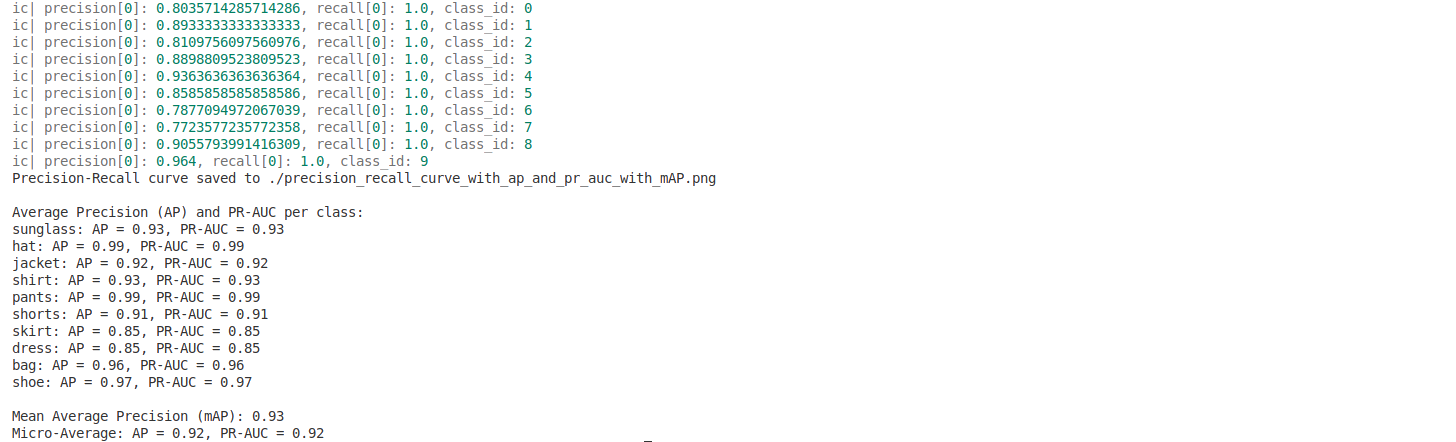

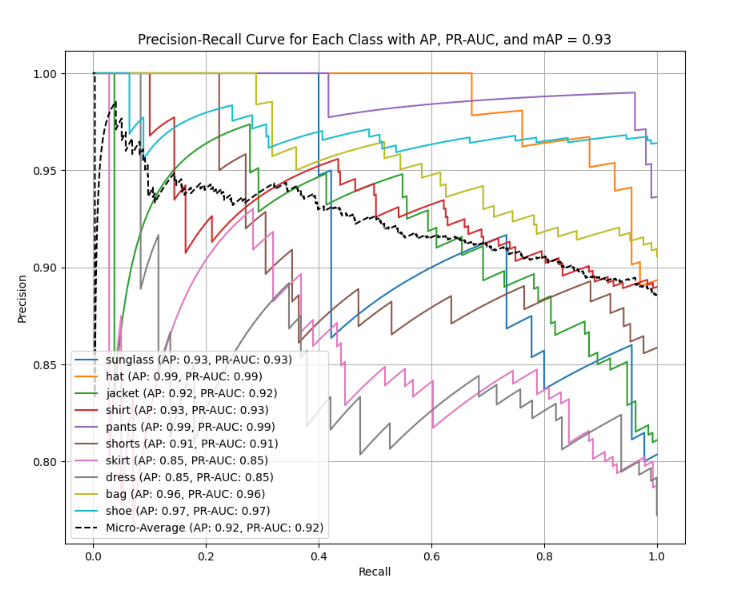

In [6]:
from IPython.display import Image, display

display(Image(filename='/home/zohreh/Pictures/Screenshots/Screenshot from 2024-09-20 00-23-05.png'))
display(Image(filename='/home/zohreh/Pictures/Screenshots/Screenshot from 2024-09-19 23-27-23.png'))



in this graph there is no significance improvement compared to the result before post processing. this might be due to the average  precision.we need further analysing.

### 5.4. Comparison of AUC-PR Curve before and after using Non-Max-Suppression and Conflict Resolution

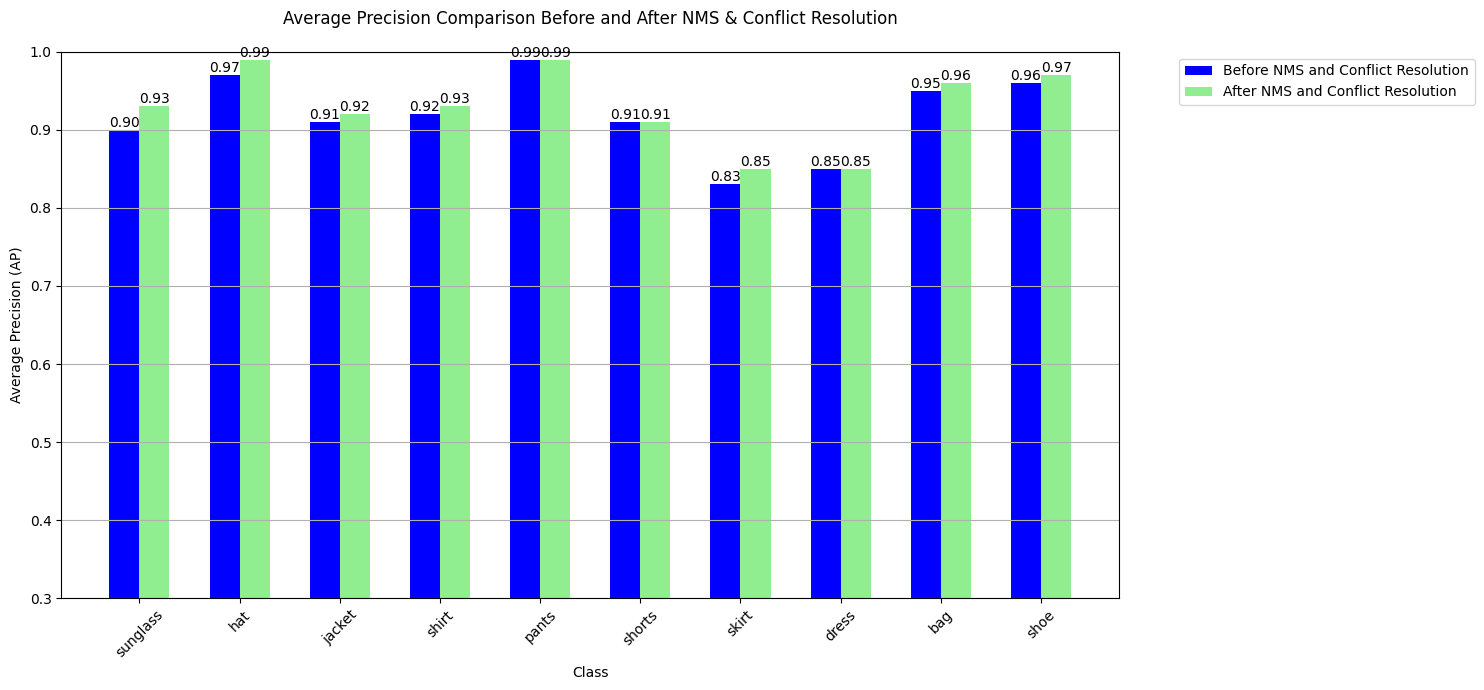

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data for AP values
ap_values_before_nms_conflict_resolution = {
    'sunglass': 0.90,
    'hat': 0.97,
    'jacket': 0.91,
    'shirt': 0.92,
    'pants': 0.99,
    'shorts': 0.91,
    'skirt': 0.83,
    'dress': 0.85,
    'bag': 0.95,
    'shoe': 0.96
}

ap_values_after_nms_conflict_resolution = {
    'sunglass': 0.93,
    'hat': 0.99,
    'jacket': 0.92,
    'shirt': 0.93,
    'pants': 0.99,
    'shorts': 0.91,
    'skirt': 0.85,
    'dress': 0.85,
    'bag': 0.96,
    'shoe': 0.97
}

# Extract class names and corresponding AP values for both cases
classes = list(ap_values_before_nms_conflict_resolution.keys())
previous_aps = [ap_values_before_nms_conflict_resolution[cls] for cls in classes]
recent_aps = [ap_values_after_nms_conflict_resolution[cls] for cls in classes]

# Define bar width and positions
bar_width = 0.3
index = np.arange(len(classes))

# Create the bar plot
plt.figure(figsize=(15, 7))
bars1 = plt.bar(index, previous_aps, bar_width, label='Before NMS and Conflict Resolution', color='blue')
bars2 = plt.bar(index + bar_width, recent_aps, bar_width, label='After NMS and Conflict Resolution', color='lightgreen')

# Add labels, title, and legend
plt.xlabel('Class')
plt.ylabel('Average Precision (AP)')
plt.title('Average Precision Comparison Before and After NMS & Conflict Resolution', pad=20)
plt.xticks(index + bar_width / 2, classes, rotation=45)
plt.ylim(0.3, 1)  # Set the y-axis range to [0.3, 1] to fit all AP values
plt.grid(True, axis='y')

# Add numbers on the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels and title
plt.show()


Across most categories, there is a slight increase in AP after post-processing, which indicates an overall improvement in model performance. This enhancement, 

although not drastic, demonstrates the positive impact of refining bounding box predictions.

#### 5.5. comparison of precision after post processing and improve baseline model predictions

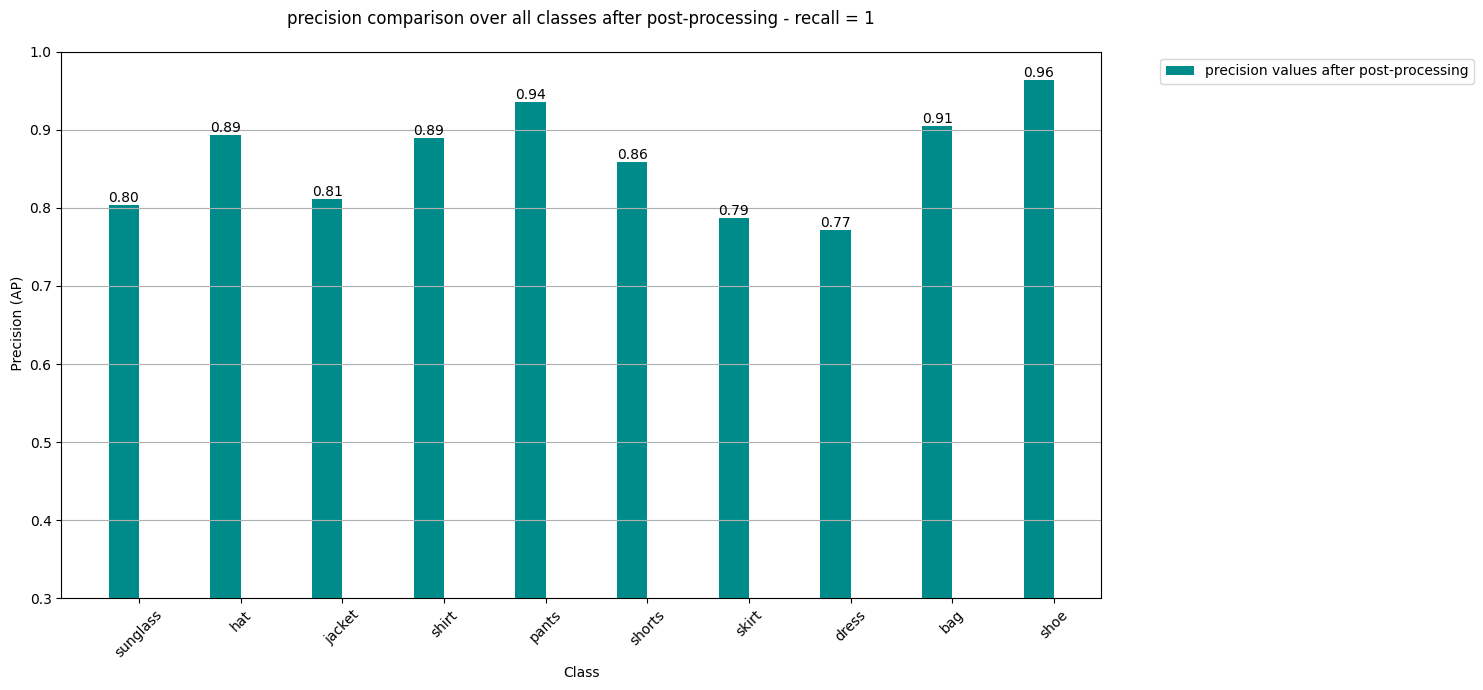

In [18]:

import matplotlib.pyplot as plt
import numpy as np

# Data for AP values
precision_values_when_recall_1 = {
    'sunglass': 0.8036,
    'hat': 0.8933 ,
    'jacket': 0.8109,
    'shirt': 0.8898 ,
    'pants': 0.9363,
    'shorts': 0.8585 ,
    'skirt': 0.7877,
    'dress': 0.7723,
    'bag': 0.9055,
    'shoe': 0.964 
}


# Extract class names and corresponding AP values for both cases
classes = list(precision_values_when_recall_1.keys())
precision_values = [precision_values_when_recall_1[cls] for cls in classes]



# Define bar width and positions
bar_width = 0.3
index = np.arange(len(classes))



# Create the bar plot
plt.figure(figsize=(15, 7))
bars1 = plt.bar(index, precision_values, bar_width, label='precision values after post-processing', color='darkcyan')



# Add labels, title, and legend
plt.xlabel('Class')
plt.ylabel(' Precision (AP)')
plt.title('precision comparison over all classes after post-processing - recall = 1', pad=20)
plt.xticks(index + bar_width / 2, classes, rotation=45)
plt.ylim(0.3, 1)  # Set the y-axis range to [0.3, 1] to fit all AP values
plt.grid(True, axis='y')



# Add numbers on the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')



# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
plt.tight_layout()  # Adjust layout to fit labels and title
plt.show()






### 5.6. Comparison of Precision in different class when recall = 1

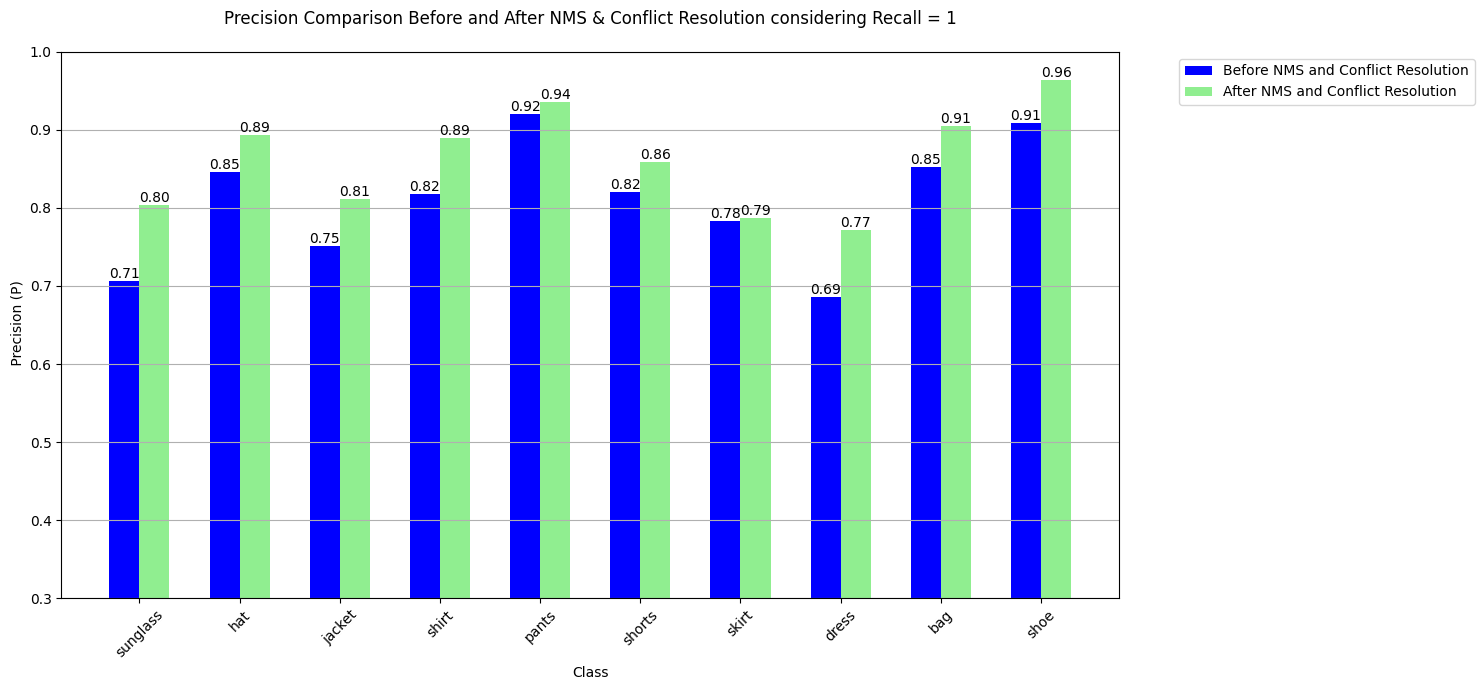

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data for AP values
ap_values_before_nms_conflict_resolution = {
    'sunglass': 0.7058,
    'hat': 0.8461,
    'jacket': 0.7513,
    'shirt': 0.8176,
    'pants': 0.9203,
    'shorts': 0.82,
    'skirt': 0.7828,
    'dress': 0.6862,
    'bag': 0.8529,
    'shoe': 0.9087
}

ap_values_after_nms_conflict_resolution = {
    'sunglass': 0.8035,
    'hat': 0.8933,
    'jacket': 0.8109,
    'shirt': 0.8898,
    'pants': 0.9363,
    'shorts': 0.8585,
    'skirt': 0.7877,
    'dress': 0.7723,
    'bag': 0.9055,
    'shoe': 0.964
}

# Extract class names and corresponding AP values for both cases
classes = list(ap_values_before_nms_conflict_resolution.keys())
previous_aps = [ap_values_before_nms_conflict_resolution[cls] for cls in classes]
recent_aps = [ap_values_after_nms_conflict_resolution[cls] for cls in classes]

# Define bar width and positions
bar_width = 0.3
index = np.arange(len(classes))

# Create the bar plot
plt.figure(figsize=(15, 7))
bars1 = plt.bar(index, previous_aps, bar_width, label='Before NMS and Conflict Resolution', color='blue')
bars2 = plt.bar(index + bar_width, recent_aps, bar_width, label='After NMS and Conflict Resolution', color='lightgreen')

# Add labels, title, and legend
plt.xlabel('Class')
plt.ylabel(' Precision (P)')
plt.title('Precision Comparison Before and After NMS & Conflict Resolution considering Recall = 1', pad=20)
plt.xticks(index + bar_width / 2, classes, rotation=45)
plt.ylim(0.3, 1)  # Set the y-axis range to [0.3, 1] to fit all AP values
plt.grid(True, axis='y')

# Add numbers on the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels and title
plt.show()


the bar chart shows the precision values for all classes have consistently improved with post-processing, especially for categories like sunglass, jacket, and bag,

highlighting the effectiveness of NMS and conflict resolution in reducing false positives. However, challenging classes like dress and skirt still show room for 

improvement, even after the post-processing step.

### 5.7. Comparing Accuracy of prediction before and after applying Non-Max-Suppression and Conflict Resolution

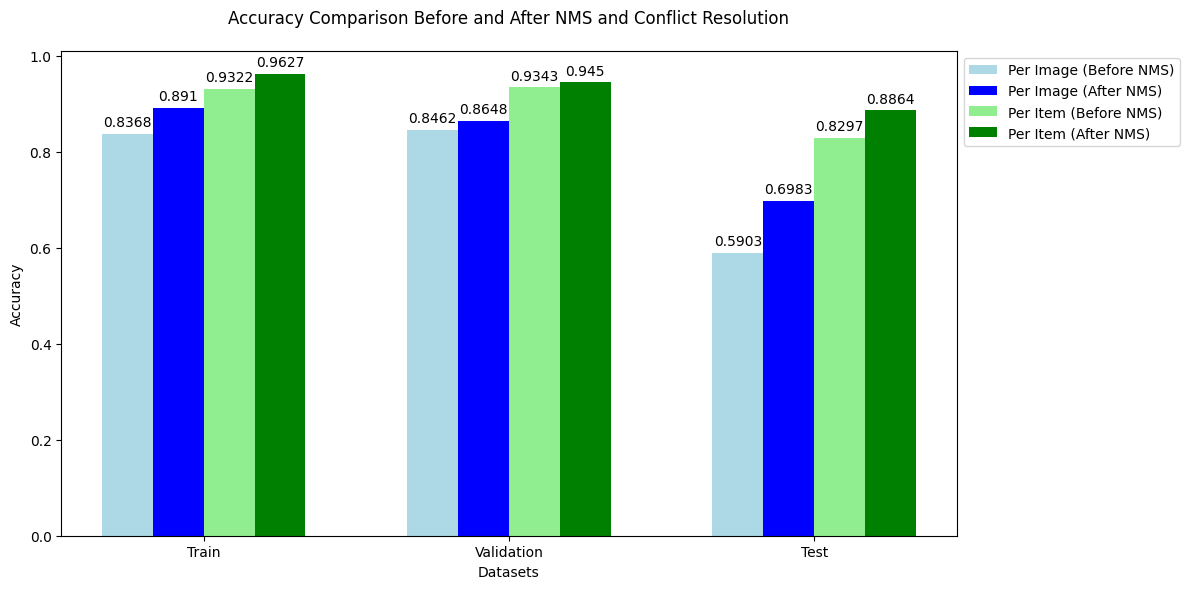

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ['Train', 'Validation', 'Test']

# Accuracy after NMS and conflict resolution
per_image_acc_after = [0.8910, 0.8648, 0.6983]
per_item_acc_after = [0.9627, 0.9450, 0.8864]

# Accuracy before NMS and conflict resolution
per_image_acc_before = [0.8368, 0.8462, 0.5903]
per_item_acc_before = [0.9322, 0.9343, 0.8297]

# Bar width and position
bar_width = 0.2
index = np.arange(len(datasets)) * 1.2  # Increase the multiplier to add more space between the groups

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the position of the bars to create space between Per Image and Per Item groups
# First group: Per Image (Before and After NMS)
bar1 = ax.bar(index - bar_width, per_image_acc_before, bar_width, label='Per Image (Before NMS)', color='lightblue')
bar2 = ax.bar(index, per_image_acc_after, bar_width, label='Per Image (After NMS)', color='blue')

# Second group: Per Item (Before and After NMS)
bar3 = ax.bar(index + bar_width, per_item_acc_before, bar_width, label='Per Item (Before NMS)', color='lightgreen')
bar4 = ax.bar(index + 2 * bar_width, per_item_acc_after, bar_width, label='Per Item (After NMS)', color='green')

# Add numbers on top of the bars
for bar in bar1 + bar2 + bar3 + bar4:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

# Labels, title, and ticks
ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison Before and After NMS and Conflict Resolution', pad=20)
ax.set_xticks(index + bar_width / 2)  # Shift ticks to align with the center of the bars
ax.set_xticklabels(datasets)

# Move the legend outside of the graph
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot with adjusted layout
plt.tight_layout()
plt.show()